# Homework 4

In [1]:
#import sys
#! yes | {sys.executable} -m pip uninstall EoN 
#!{sys.executable} -m pip install EoN 

In [2]:
import networkx as nx
import EoN as eon
import pandas as pd
import matplotlib.pyplot as plt
from numpy import exp
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import numpy as np

from statistics import mean
from scipy.stats import pearsonr

In [3]:
# Read the graph(ignore weights)
flu_G = pd.read_csv('fludata.txt', sep="\t", header=None,names=["source", "target", "w"])
flu_G = flu_G.drop('w',axis=1)

flu_G = nx.from_pandas_edgelist(flu_G)

## Part 1

### A) Plot Infected Individuals Over Time

In [4]:
tmax = 10
beta = 0.01      # transmission rate
mu = 0.5         # recovery rate
initial_infected = 325 #node of initial infected 

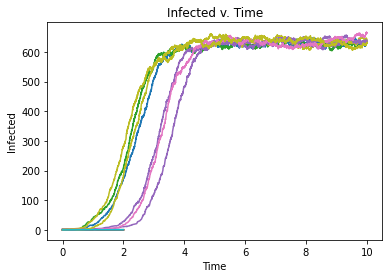

In [5]:
plt.figure()
plt.title('Infected v. Time')
plt.xlabel('Time')
plt.ylabel('Infected')

#some seem to be roughly sigmoidal while in some case very few if any new infections occur
import seaborn as sns
colors = sns.color_palette(None, 10)
for i in range(10):
    t, S, I = eon.fast_SIS(flu_G,tau=beta,gamma=mu,initial_infecteds=initial_infected,tmax=tmax)
    plt.plot(t, I,colors[i])

### In most simulations the number of infected evolves almost logistically. In select few cases however, initial infection results in few if any new infections

---
### B) Actual VS Estimated Infected

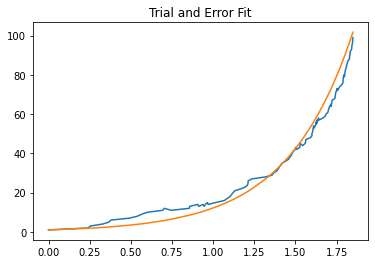

In [6]:
time, S, I = eon.fast_SIS(flu_G,tau=beta,gamma=mu,initial_infecteds=initial_infected,tmax=tmax)
observations = [(a,b) for a,b in zip(time,I)]

select_time = [time for (time,I) in observations if I < 100]
select_observations = [I for (time,I) in observations if I < 100]

#guessing value by trial and error
tau = 0.4
model = [exp(t/tau) for t in select_time]

plt.figure()
plt.title('Trial and Error Fit')
plt.plot(select_time, select_observations)
plt.plot(select_time, model)

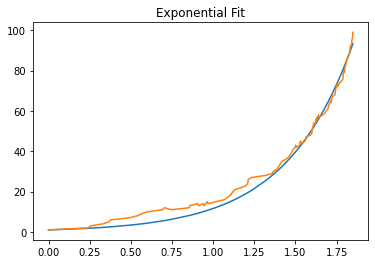

In [7]:
#fitting with scipy
def func(t, tau):
    I =  exp(t/tau)
    return I

popt, pcov = curve_fit(func, select_time, select_observations)
y = func(select_time, *popt)
plt.figure()
plt.title('Exponential Fit')
plt.plot(select_time, y)
plt.plot(select_time, select_observations)

### Value from curve fitting

In [8]:
print('Parameter Estimate:' , popt[0])
print('R-Squared Error:', r2_score(select_observations,y))

Parameter Estimate: 0.4075937514946198
R-Squared Error: 0.9891987834440009


---
### C) Simulated VS Theoretical Estimates of $\tau$

In [9]:
# Run several times (25x or more) to compute distribution of tau

tau_list = []
for i in range(30):
    time, S, I = eon.fast_SIS(flu_G,tau=beta,gamma=mu,initial_infecteds=initial_infected,tmax=tmax)
    observations = [(a,b) for a,b in zip(time,I)]

    #break if simulation ends in less than 10 infected
    if(I[-1] >= 10):
        select_time = [time for (time,I) in observations if I < 100]
        select_observations = [I for (time,I) in observations if I < 100]
    
        popt, pcov = curve_fit(func, select_time, select_observations)
        y = func(select_time, *popt)
    
        tau = popt[0]
    
        tau_list.append(tau)
    else:
        continue #do not acount for outlier parameters

In [10]:
#list of degrees
degrees = [val for (node, val) in flu_G.degree()]
#average degree
k_bar = mean(degrees)
#number of nodes (population size)
N = flu_G.number_of_nodes()

k_2 = [k ** 2 for k in degrees]

k_2_bar = sum(k_2)/N

The corresponding expected value is below $$ \tau = \frac{1}{\bar{k}*\beta - \mu} $$

In [11]:
tau1 = 1/((k_bar*beta)-mu)
print('Result 1:',tau1)

Result 1: 0.3996307979430171


$$ \tau = \frac{\bar{k}}{\beta * \bar{k^2} - (\beta + \mu)*\bar{k}} $$

In [12]:
tau2 = k_bar/((beta*k_2_bar)-(beta+mu)*k_bar)
print('Result 2:', tau2)

Result 2: 0.3511723041185225


$$ \tau = \frac{\bar{k}}{\beta * \bar{k^2} - \mu * \bar{k}} $$

In [13]:
tau3 = k_bar/((beta*k_2_bar) - mu*k_bar)
print('Results 3:', tau3)

Results 3: 0.34994339981827


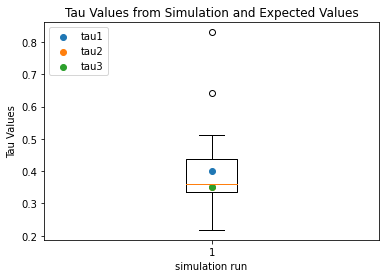

In [14]:
tau_computations = [tau1,tau2,tau3]

plt.figure()
plt.scatter(1,tau1,label = 'tau1')
plt.scatter (1,tau2,label = 'tau2')
plt.scatter(1,tau3,label = 'tau3')
plt.boxplot(tau_list)
plt.title('Tau Values from Simulation and Expected Values')
plt.xlabel('simulation run')
plt.ylabel('Tau Values')
plt.legend(loc="upper left")

Which distributions match your simulation results most accurately?


Tau1, using the 'random 'distribution' from canvas, matches the simulation results the best.

---
### D) Infection at the Endemic State



Compute the theoretical expected value of $i(\infty)$:


In [15]:
perc_infected_list = []
for i in range(30):
    time, S, I = eon.fast_SIS(flu_G,tau=beta,gamma=mu,initial_infecteds=initial_infected,tmax=tmax)
    observations = [(a,b) for a,b in zip(time,I)]

    #break if simulation ends in less than 10 infected
    if(I[-1] >= 10):
        
        #specifying endemic state as after t=4
        select_time = [time for (time,I) in observations if time > 4 ]
        select_observations = [I for (time,I) in observations if time > 4]
        
        infected_count = mean(select_observations)
        
        # percentage of the population that remains infected at the endemic state
        perc_infected = infected_count/N
        
        perc_infected_list.append(perc_infected)
    

    else:
        continue #do not acount for die out cases
    

0.8334615482158406


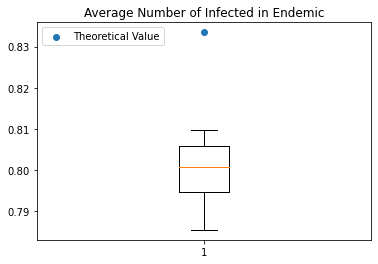

In [16]:
#theoretical value 
value = 1-mu/(k_bar*beta)
print(value)
        
plt.figure();
plt.title('Average Number of Infected in Endemic');
plt.boxplot(perc_infected_list);
plt.scatter(1,value,label = 'Theoretical Value');
plt.legend(loc="upper left");

---
## Part 2

### A) Varying Transmission Rate $\beta$

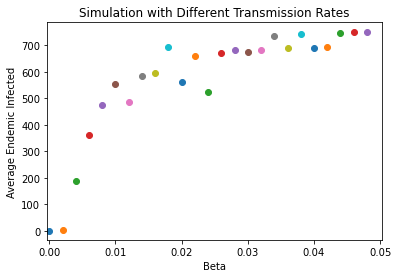

In [18]:
betas = np.arange(0, 0.05, 0.002)

all_simulations = []
endemic_end = []
averages = []

for beta in betas:
    endemic_end = []
    for j in range(15):
        time, S, I = eon.fast_SIS(flu_G,tau=beta,gamma=mu,initial_infecteds=initial_infected,tmax=tmax)
        end_count = I[-1]
        endemic_end.append(end_count)
        if j == 9 :
            all_simulations.append(endemic_end)
    
        
    

for collection in all_simulations:
    average = mean(collection)
    averages.append(average)
    

data_points = [(a,b) for a,b in zip(betas,averages)]

plt.figure()
plt.title('Simulation with Different Transmission Rates')
plt.xlabel('Beta')
plt.ylabel('Average Endemic Infected')
for pair in data_points:
    plt.scatter(pair[0],pair[1])

---
### B) Minimum Transmission Rate for Epidemic

### **Instructions are quite confusing!** 

Compute theoretical values for minimum $\beta$ required for epidemic to occur:

**Random distribution:**

In [24]:
# for a random degree distribution
beta_rand = mu * 1/k_bar
beta_rand

0.0016653845178415938

**Arbitrary distribution:**

In [25]:
# for an arbitrary distribution
beta_arb = mu * k_bar/k_2_bar
beta_arb

0.0014891567169036176

**Beta Theoretical And Experimental Calculation**

/var/folders/09/62sx_xj1601d6m4fg6k_jjxh0000gn/T/ipykernel_25346/1132549155.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  I = N * (1-(mu/(beta*k_bar)))


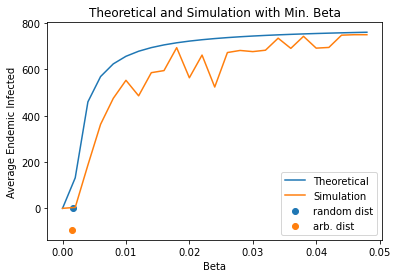

In [23]:
# Compute the theoretical number of infected individuals with different betas as well as the simulation.
# Plot those two curves in one plot and compare them.
def infected(beta):
    I = N * (1-(mu/(beta*k_bar)))
    return I

#two points
I_rand = N * (1-(mu/(beta_rand*k_bar)))
I_arb = N * (1-(mu/(beta_arb*k_bar)))

theoretical_curve = [infected(beta) for beta in betas]

#correcting for negative values
theoretical_curve = [0 if i < 0 else i for i in theoretical_curve]

plt.figure()
plt.title('Theoretical and Simulation with Min. Beta')
plt.plot(betas,theoretical_curve, label = 'Theoretical')
plt.xlabel('Beta')
plt.ylabel('Average Endemic Infected')
plt.plot(betas,averages, label = 'Simulation')
plt.scatter(beta_rand,I_rand, label = 'random dist')
plt.scatter(beta_arb,I_arb, label = 'arb. dist')
plt.legend(loc="lower right")

---
## Part 3

### A) Patient-0 Centrality & $\tau$

### takes a while

In [26]:
# Run simulations with each node as initial infected and compute tau
nodes = list(flu_G.nodes())
tau_estimates = []
for node in nodes:
    
    time, S, I = eon.fast_SIS(flu_G,tau=beta,gamma=mu,initial_infecteds=node,tmax=5)
    
    observations = [(a,b) for a,b in zip(time,I)]

    select_time = [time for (time,I) in observations if I < 100]
    select_observations = [I for (time,I) in observations if I < 100]
    
    popt, pcov = curve_fit(func, select_time, select_observations)
    
    tau_estimate = popt[0]
    tau_estimates.append(tau_estimate)
    

/Users/jarodw/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [27]:
# Compute centrality metrics
deg_cen = nx.degree_centrality(flu_G)
close_cen = nx.closeness_centrality(flu_G)
betw_cen = nx.betweenness_centrality(flu_G)
eig_cen = nx.eigenvector_centrality(flu_G)

In [28]:
nodes = list(flu_G.nodes())

node_tau_pairs = [(a,b) for a,b in zip(nodes,tau_estimates)]

In [29]:
#cleaning results
node_tau_pairs = [pair for pair in node_tau_pairs if pair[1] < 2]

node_tau_pairs = pd.DataFrame(node_tau_pairs, columns =['node', 'tau'])

   node       tau   deg_cen  close_cen  betw_cen   eig_cen
0     1  0.174903  0.069886   0.515727  0.000030  0.005834
1    11  0.099954  0.357052   0.608192  0.000660  0.030356
2    37  0.134380  0.348158   0.604919  0.000651  0.029510
3    90  0.189369  0.213469   0.559346  0.000279  0.018061
4   137  0.069958  0.372300   0.614364  0.000591  0.033559


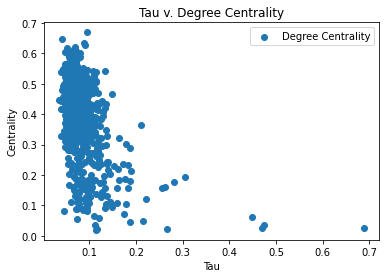

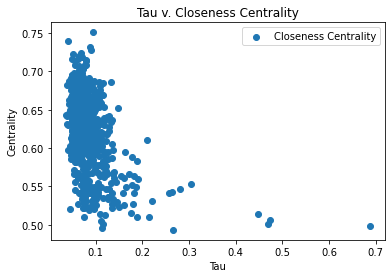

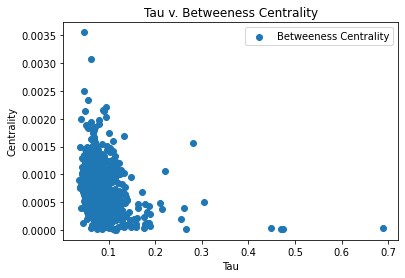

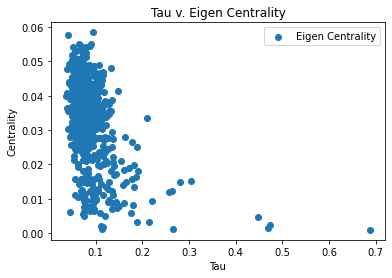

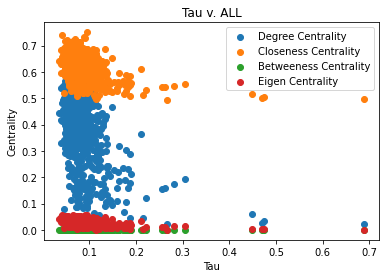

In [30]:
node_deg_cen_pairs = pd.DataFrame(list(deg_cen.items()),columns =['node', 'deg_cen'])
node_close_cen_pairs = pd.DataFrame(list(close_cen.items()),columns =['node', 'close_cen'])
node_betw_cen_pairs = pd.DataFrame(list(betw_cen.items()),columns =['node', 'betw_cen'])
node_eig_cen_pairs = pd.DataFrame(list(eig_cen.items()),columns =['node', 'eig_cen'])

results = node_tau_pairs.merge(node_deg_cen_pairs, on = 'node', how = 'left')
results = results.merge(node_close_cen_pairs, on = 'node', how = 'left')
results = results.merge(node_betw_cen_pairs, on = 'node', how = 'left')
results = results.merge(node_eig_cen_pairs, on = 'node', how = 'left')

print(results.head())


plt.figure()
plt.title('Tau v. Degree Centrality')
plt.xlabel('Tau')
plt.ylabel('Centrality')
plt.scatter(results.tau,results.deg_cen,label = 'Degree Centrality')
plt.legend(loc="upper right")

plt.figure()
plt.title('Tau v. Closeness Centrality')
plt.xlabel('Tau')
plt.ylabel('Centrality')
plt.scatter(results.tau,results.close_cen,label = 'Closeness Centrality')
plt.legend(loc="upper right")

plt.figure()
plt.title('Tau v. Betweeness Centrality')
plt.xlabel('Tau')
plt.ylabel('Centrality')
plt.scatter(results.tau,results.betw_cen,label = 'Betweeness Centrality')
plt.legend(loc="upper right")

plt.figure()
plt.title('Tau v. Eigen Centrality')
plt.xlabel('Tau')
plt.ylabel('Centrality')
plt.scatter(results.tau,results.eig_cen,label = 'Eigen Centrality')
plt.legend(loc="upper right")

plt.figure()
plt.title('Tau v. ALL')
plt.xlabel('Tau')
plt.ylabel('Centrality')
plt.scatter(results.tau,results.deg_cen,label = 'Degree Centrality')
plt.scatter(results.tau,results.close_cen,label = 'Closeness Centrality')
plt.scatter(results.tau,results.betw_cen,label = 'Betweeness Centrality')
plt.scatter(results.tau,results.eig_cen,label = 'Eigen Centrality')
plt.legend(loc="upper right")



---
### B) Correlation between centrality and $\tau$

In [31]:
# Compute the Pearson correlation coefficient

r1,p1 = pearsonr(results.tau,results.deg_cen)
r2,p2 = pearsonr(results.tau,results.close_cen)
r3,p3 = pearsonr(results.tau,results.betw_cen)
r4,p4 = pearsonr(results.tau,results.eig_cen)


print('Coeff:',r1,r2,r3,r4)
print('p-value',p1,p2,p3,p4)
mean([r1,r2,r3,r4])

Coeff: -0.454655266698609 -0.432600199749284 -0.30228363342062753 -0.45548559760328866
p-value 1.0978059015904452e-39 1.0857892332471465e-35 2.2458483130249362e-17 7.661518537792303e-40


-0.4112561743679523

All 4 pearsons correlation coeff. returned with a negative value with an average of -0.38. Further, all p-values returned were exceptionally small, $ p << 0.001 $. We can thus reject the null hypothesis that $\tau$ and the centrality metrics are not correlated with a 99% confidence level.

---
### C) Centrality as an Outbreak Predictor

The order here, from best to worst is:
1. Degree Centrality
2. Closeness Centrality
3. Eigen Centrality
4. Betweeness Centrality

Comment on your observations:

All centrality metrics have significant correlation with $ \tau$. The results suggest that degree, closeness, and eigen centrality correlate roughly the same. All three have a stronger correlation than $\tau$ and betweeness centrality. This suggest the degree centrality would serve as the best predictior of how fast an outbreak would occur resulting in an endemic state.



## Part 4 - Knowledge Question

Your answer to the modularity proof food for thought here

let $ f_1,f_2,...,f_n $ be any submodular function and let $\alpha_1,\alpha_2,...\alpha_3$ be any non-negative numbers such that $$ g(X) = \sum{\alpha_i f_i(X)} $$

$\Rightarrow$ 

Define $A$ as folllows $$ g(v \cup X) - g(X) = \sum{\alpha_i f_i(v \cup X) - \sum{\alpha f_i(X)}} = \underbrace{\alpha_1 f_1(v \cup X) - \alpha f_1(X)}_{A_1} + ... + \underbrace{\alpha_n f_n(v \cup X) - \alpha_nF_n(X)}_{A_n}$$

Define $B$ as follows

$$ g(v \cup T) - g(T) = \sum{\alpha_i f_i(v \cup T) - \sum{\alpha f_i(T)}} = \underbrace{\alpha_1 f_1(v \cup T) - \alpha f_1(T)}_{B_1} + ... + \underbrace{\alpha_n f_n(v \cup T) - \alpha_nF_n(T)}_{B_n}$$


Thus $\exists$ a one-to-one relation ship for all terms $A_i$ to a corresponding term $B_i$. Further, from submodularity of all $f_i$, $A_i \ge B_i ,\forall i$

It follows then 

$$\sum{A_i}\ge\sum{B_i} \Longleftrightarrow g(v \cup X) - g(X) \ge g(v \cup T) - g(T) $$

and thus $g(X)$ is submodular. $\square$


